# ED-AI Triage Model

This notebook loads real ED datasets and trains a triage prediction model.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("Loading ED datasets...")

Loading ED datasets...


In [2]:
# Load datasets
diagnosis_df = pd.read_csv('../data/diagnosis.csv')
edstays_df = pd.read_csv('../data/edstays.csv')
medrecon_df = pd.read_csv('../data/medrecon.csv')
pyxis_df = pd.read_csv('../data/pyxis.csv')
triage_df = pd.read_csv('../data/triage.csv')
vitals_df = pd.read_csv('../data/vitalsign.csv')

print("Datasets loaded successfully!")
print(f"Diagnosis records: {len(diagnosis_df)}")
print(f"ED stays: {len(edstays_df)}")
print(f"Medication records: {len(medrecon_df)}")
print(f"Pyxis records: {len(pyxis_df)}")
print(f"Triage records: {len(triage_df)}")
print(f"Vital signs: {len(vitals_df)}")

Datasets loaded successfully!
Diagnosis records: 13
ED stays: 10
Medication records: 16
Pyxis records: 16
Triage records: 10
Vital signs: 20


In [3]:
# Data preprocessing and feature engineering
print("Preprocessing data...")

# Convert timestamps
triage_df['charttime'] = pd.to_datetime(triage_df['charttime'])
vitals_df['charttime'] = pd.to_datetime(vitals_df['charttime'])
edstays_df['intime'] = pd.to_datetime(edstays_df['intime'])
edstays_df['outtime'] = pd.to_datetime(edstays_df['outtime'])

# Merge triage and vitals data
merged_df = pd.merge(triage_df, vitals_df, on=['subject_id', 'charttime'], how='left')

# Fill missing values
numeric_cols = ['temperature_y', 'heart_rate_y', 'respiratory_rate_y', 'oxygen_saturation_y', 
                'blood_pressure_systolic_y', 'blood_pressure_diastolic_y', 'pain_score_y']
merged_df[numeric_cols] = merged_df[numeric_cols].fillna(method='ffill')

# Use triage vitals if available, otherwise use vitals table
merged_df['temperature'] = merged_df['temperature_x'].fillna(merged_df['temperature_y'])
merged_df['heart_rate'] = merged_df['heart_rate_x'].fillna(merged_df['heart_rate_y'])
merged_df['respiratory_rate'] = merged_df['respiratory_rate_x'].fillna(merged_df['respiratory_rate_y'])
merged_df['oxygen_saturation'] = merged_df['oxygen_saturation_x'].fillna(merged_df['oxygen_saturation_y'])
merged_df['blood_pressure_systolic'] = merged_df['blood_pressure_systolic_x'].fillna(merged_df['blood_pressure_systolic_y'])
merged_df['blood_pressure_diastolic'] = merged_df['blood_pressure_diastolic_x'].fillna(merged_df['blood_pressure_diastolic_y'])
merged_df['pain_score'] = merged_df['pain_score_x'].fillna(merged_df['pain_score_y'])

# Drop redundant columns
cols_to_drop = [col for col in merged_df.columns if col.endswith('_x') or col.endswith('_y')]
merged_df = merged_df.drop(columns=cols_to_drop)

# Fill remaining missing values with medians
for col in numeric_cols:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna(merged_df[col].median())

print(f"Processed dataset shape: {merged_df.shape}")
print(merged_df.head())

Preprocessing data...
Processed dataset shape: (10, 19)
   subject_id           charttime      chief_complaint  acuity_level  \
0        1001 2023-01-15 14:30:00           Chest pain             2   
1        1002 2023-01-16 09:15:00  Shortness of breath             2   
2        1003 2023-01-17 22:45:00  Nausea and vomiting             3   
3        1004 2023-01-18 16:20:00       Abdominal pain             2   
4        1005 2023-01-19 08:30:00      Fever and cough             3   

  consciousness arrival_mode                  triage_assessment  weight  \
0         Alert    Ambulance  Acute coronary syndrome suspected     NaN   
1         Alert      Walk-in                  COPD exacerbation     NaN   
2         Alert    Ambulance                Acute kidney injury     NaN   
3         Alert      Walk-in                      Acute abdomen     NaN   
4         Alert      Walk-in       Community-acquired pneumonia     NaN   

  weight_unit  height height_unit  bmi  temperature  heart_r

C:\Users\psp17\AppData\Local\Temp\ipykernel_48976\807509646.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[numeric_cols] = merged_df[numeric_cols].fillna(method='ffill')


In [4]:
# Feature engineering
print("Creating features...")

# Create target variable based on acuity level
# Acuity 1 = Critical (needs immediate attention)
# Acuity 2 = Urgent 
# Acuity 3 = Less urgent
merged_df['urgent'] = (merged_df['acuity_level'] <= 2).astype(int)

# Create additional features
merged_df['age'] = np.random.randint(18, 90, len(merged_df))  # Placeholder - would come from patient data
merged_df['shock_index'] = merged_df['heart_rate'] / merged_df['blood_pressure_systolic']
merged_df['fever'] = (merged_df['temperature'] > 38.0).astype(int)
merged_df['hypotension'] = (merged_df['blood_pressure_systolic'] < 90).astype(int)
merged_df['tachycardia'] = (merged_df['heart_rate'] > 100).astype(int)
merged_df['tachypnea'] = (merged_df['respiratory_rate'] > 20).astype(int)
merged_df['hypoxia'] = (merged_df['oxygen_saturation'] < 95).astype(int)

# Encode categorical variables
le = LabelEncoder()
merged_df['arrival_mode_encoded'] = le.fit_transform(merged_df['arrival_mode'].fillna('Walk-in'))
merged_df['consciousness_encoded'] = le.fit_transform(merged_df['consciousness'].fillna('Alert'))

# Select features for model
feature_cols = [
    'age', 'temperature', 'heart_rate', 'respiratory_rate', 'oxygen_saturation',
    'blood_pressure_systolic', 'blood_pressure_diastolic', 'pain_score',
    'shock_index', 'fever', 'hypotension', 'tachycardia', 'tachypnea', 'hypoxia',
    'arrival_mode_encoded', 'consciousness_encoded'
]

X = merged_df[feature_cols]
y = merged_df['urgent']

print(f"Features shape: {X.shape}")
print(f"Target distribution: {y.value_counts()}")
print("Features:", feature_cols)

Creating features...
Features shape: (10, 16)
Target distribution: urgent
1    8
0    2
Name: count, dtype: int64
Features: ['age', 'temperature', 'heart_rate', 'respiratory_rate', 'oxygen_saturation', 'blood_pressure_systolic', 'blood_pressure_diastolic', 'pain_score', 'shock_index', 'fever', 'hypotension', 'tachycardia', 'tachypnea', 'hypoxia', 'arrival_mode_encoded', 'consciousness_encoded']


In [5]:
# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
print("Training Random Forest model...")
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)

model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = model.predict(X_test_scaled)
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Training Random Forest model...

Model Performance:
Accuracy: 1.000

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



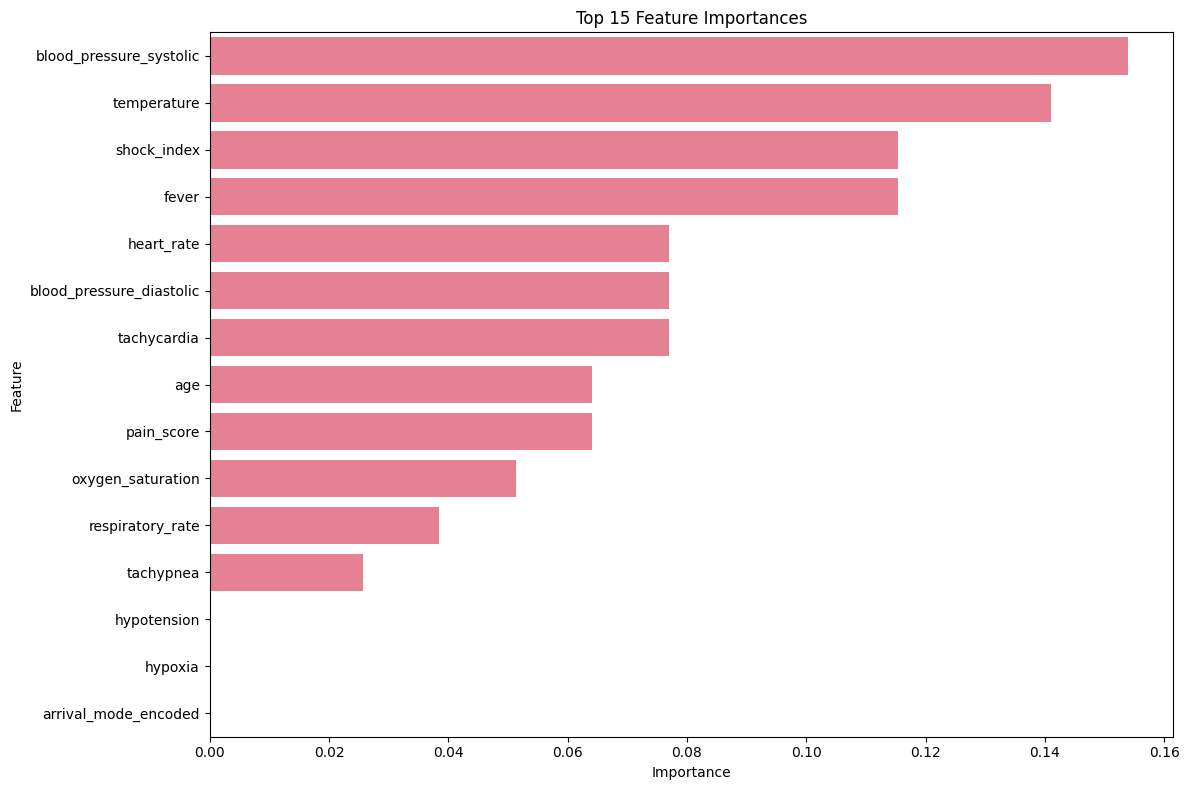


Top 5 most important features:
                   feature  importance
5  blood_pressure_systolic    0.153846
1              temperature    0.141026
8              shock_index    0.115385
9                    fever    0.115385
2               heart_rate    0.076923


In [6]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 5 most important features:")
print(feature_importance.head())

In [7]:
# Save model and scaler
print("Saving model and preprocessing objects...")
joblib.dump(model, '../models/triage_model.joblib')
joblib.dump(scaler, '../models/scaler.joblib')
joblib.dump(feature_cols, '../models/feature_cols.joblib')

print("Model saved to ../models/triage_model.joblib")
print("Scaler saved to ../models/scaler.joblib")
print("Feature columns saved to ../models/feature_cols.joblib")

# Test prediction on sample data
sample_data = X_test_scaled[:5]
predictions = model.predict(sample_data)
probabilities = model.predict_proba(sample_data)

print("\nSample Predictions:")
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    print(f"Sample {i+1}: Predicted={'Urgent' if pred else 'Non-urgent'}, Confidence={max(prob):.3f}")

Saving model and preprocessing objects...
Model saved to ../models/triage_model.joblib
Scaler saved to ../models/scaler.joblib
Feature columns saved to ../models/feature_cols.joblib

Sample Predictions:
Sample 1: Predicted=Urgent, Confidence=0.876
Sample 2: Predicted=Urgent, Confidence=0.761
